In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version


# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

1.7.0 True
2.11.0
11.0
GCC 7.3


# axis alignment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image, ImageDraw
from distinctipy import distinctipy

In [3]:
from src.axis_alignment.utils import dict2class, AxisAlignment

In [4]:
colors = distinctipy.get_colors(30)

In [5]:
opt = {
    # region detection
    "config_file": "./checkpoints/axis_alignment/fcos_x101_64x4d_fpn_gn-head_mstrain_640-800_2x_coco.py",
    "checkpoint_file": "./checkpoints/axis_alignment/epoch_200.pth",
    "refinement": True,
    # tick detection
    "cuda": True,
    "canvas_size": 1280,
    "mag_ratio": 1.5,
    "poly": False,
    "text_threshold": 0.7,
    "low_text": 0.4,
    "link_threshold": 0.7,
    "show_time": False,
    "refine": True,
    "trained_model": './checkpoints/axis_alignment/craft_mlt_25k.pth',
    "refiner_model": './checkpoints/axis_alignment/craft_refiner_CTW1500.pth',
    # tick recognition
    "workers": 4,
    "saved_model": "./checkpoints/axis_alignment/TPS-ResNet-BiLSTM-Attn.pth",
    "batch_max_length": 25,
    "imgH": 32,
    "imgW": 100,
    "rgb": False,
    "character": "0123456789abcdefghijklmnopqrstuvwxyz",
    "sensitive": False,
    "PAD": True,
    "Transformation": "TPS",
    "FeatureExtraction": "ResNet",
    "SequenceModeling": "BiLSTM",
    "Prediction": "Attn",
    "num_fiducial": 20,
    "input_channel": 1,
    "output_channel": 512,
    "hidden_size": 256,
    
}  

In [6]:
axis_alignment = AxisAlignment(opt)

build plot detector ...
Use load_from_local loader
model input parameters 32 100 20 1 512 256 38 25 TPS ResNet BiLSTM Attn
loading pretrained model from ./checkpoints/axis_alignment/TPS-ResNet-BiLSTM-Attn.pth


## IMPORTANT
### set path of graph images

In [7]:
path = "/home/weixin/Documents/data/MaterialEyes/plot_digitzer/region_detection/test_graph_20210529/"
axis_alignment.load_data(path)


In [8]:
img, plot_bbox, results, results_all = axis_alignment.run(30)

/home/weixin/Documents/GitProjects/mmdetection/mmdet/datasets/utils.py:64: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/weixin/Documents/GitProjects/Plot2Spec/src/axis_alignment/tick_detection/craft_utils.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)


In [9]:
plot_bbox, results#, results_all

((64.0, 3.7215593, 323.6144, 351.0),
 [['675',
   0.9667821526527405,
   array([ 50.666668, 362.66666 ,  78.666664, 377.33334 ], dtype=float32)],
  ['12200',
   0.13208898901939392,
   array([158.66667, 362.66666, 198.66667, 377.33334], dtype=float32)],
  ['1500',
   0.9829277992248535,
   array([224.     , 362.66666, 262.66666, 377.33334], dtype=float32)],
  ['1800',
   0.9956688284873962,
   array([288.     , 362.66666, 326.66666, 378.66666], dtype=float32)]])

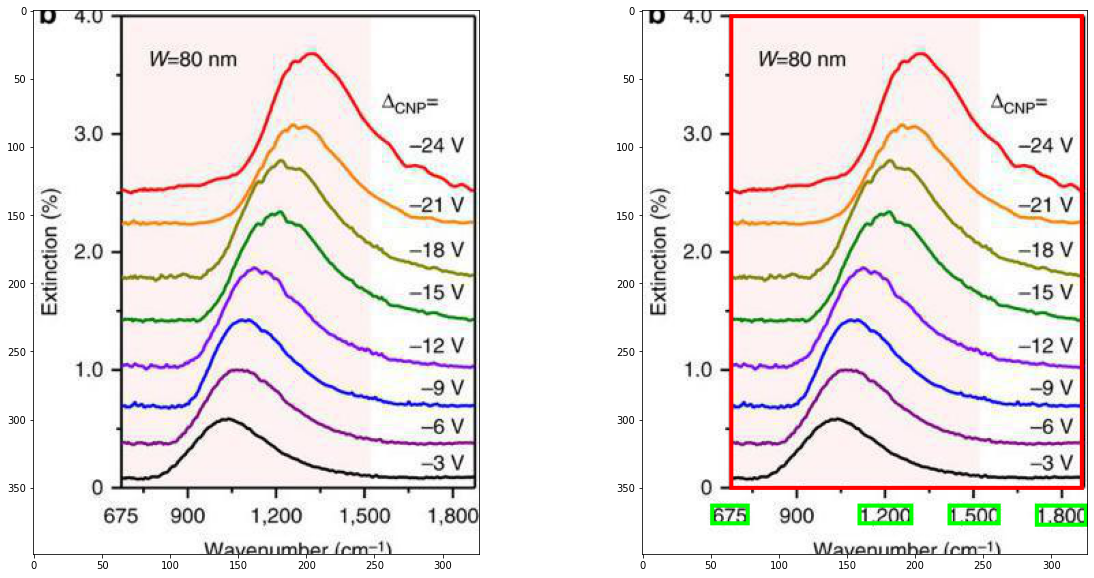

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)
draw.rectangle(list(plot_bbox), outline=(255,0,0), width=3)

for idx, tick in enumerate(results):
    draw.rectangle(list(tick[2]), outline=(0,255,0), width=3)

plt.imshow(img_draw)

In [11]:
region_path = "./data/regions"
axis_alignment.crop(region_path)

100%|██████████| 1000/1000 [03:10<00:00,  5.25it/s]


# plot data extraction

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import os
import json
from distinctipy import distinctipy

In [13]:
from src.plot_data_extraction.plot_digitizer import PlotDigitizer
from src.plot_data_extraction.SpatialEmbeddings.src.utils import transforms as my_transforms
from src.plot_data_extraction.evaluation import PlotEvaluator
from src.plot_data_extraction.utils import GenerateTestData, dict2class

In [14]:
colors = distinctipy.get_colors(30)

In [15]:
GenerateTestData("./data/regions/", 
                 "./data/input_plot_extraction")

In [16]:
opt = {
    "cuda": True,
    "display": False,
    "save": True,
    "save_dir": "./exp/",
    "root": "./data/input_plot_extraction/leftImg8bit/",
    "data_type": "test",
    "mode": "raman_xanes",
    "num_workers": 6,
    "model_file": "./checkpoints/plot_data_extraction/lanenet/deeplab_all_checkpoint/0999_checkpoint.ckpt",
    "checkpoint_path": "./checkpoints/plot_data_extraction/checkpoint_0999.pth",

    
    "dataset": {
        'name': 'cityscapes',
        'kwargs': {
            'root_dir': "./data/input_plot_extraction",
            'type': 'test',
            'transform': my_transforms.get_transform([
                {
                    "name": "CustomResizePad",
                    "opts": {
                        'keys': ('image', 'instance','label'),
                        "is_test": True,
                    },
                },
                {
                    'name': 'ToTensor',
                    'opts': {
                        'keys': ('image', 'instance', 'label'),
                        'type': (torch.FloatTensor, torch.ByteTensor, torch.ByteTensor),
                    }
                },
                {
                    'name': 'Normalize',
                    'opts': {
                        'keys': ('image'),
                        'p': -1,
                    }
                },
            ]),
        }
    },
    
    "model": {
        'name': 'branched_erfnet',
        'kwargs': {
            'num_classes': [3, 1],
        }
    }
}

In [17]:
plot_digitizer = PlotDigitizer()
plot_digitizer.load_seg("spatialembedding", opt)
len(plot_digitizer.instance_seg)

Creating branched erfnet with [3, 1] classes
Resuming model from ./checkpoints/plot_data_extraction/checkpoint_0999.pth
Cityscapes Dataset created


1000

## IMPORTANT
### set img_id

In [52]:
img_id =202
plot_digitizer.predict_from_ins_seg(img_id)
plot_digitizer.img_name

estimated linewidth: 9.0
estimated num of plots: 2


'./data/input_plot_extraction/leftImg8bit/test/raman_xanes/000_s41598-017-11931-5_fig1.png'

Text(0.5, 1.0, 'instance segmentation')

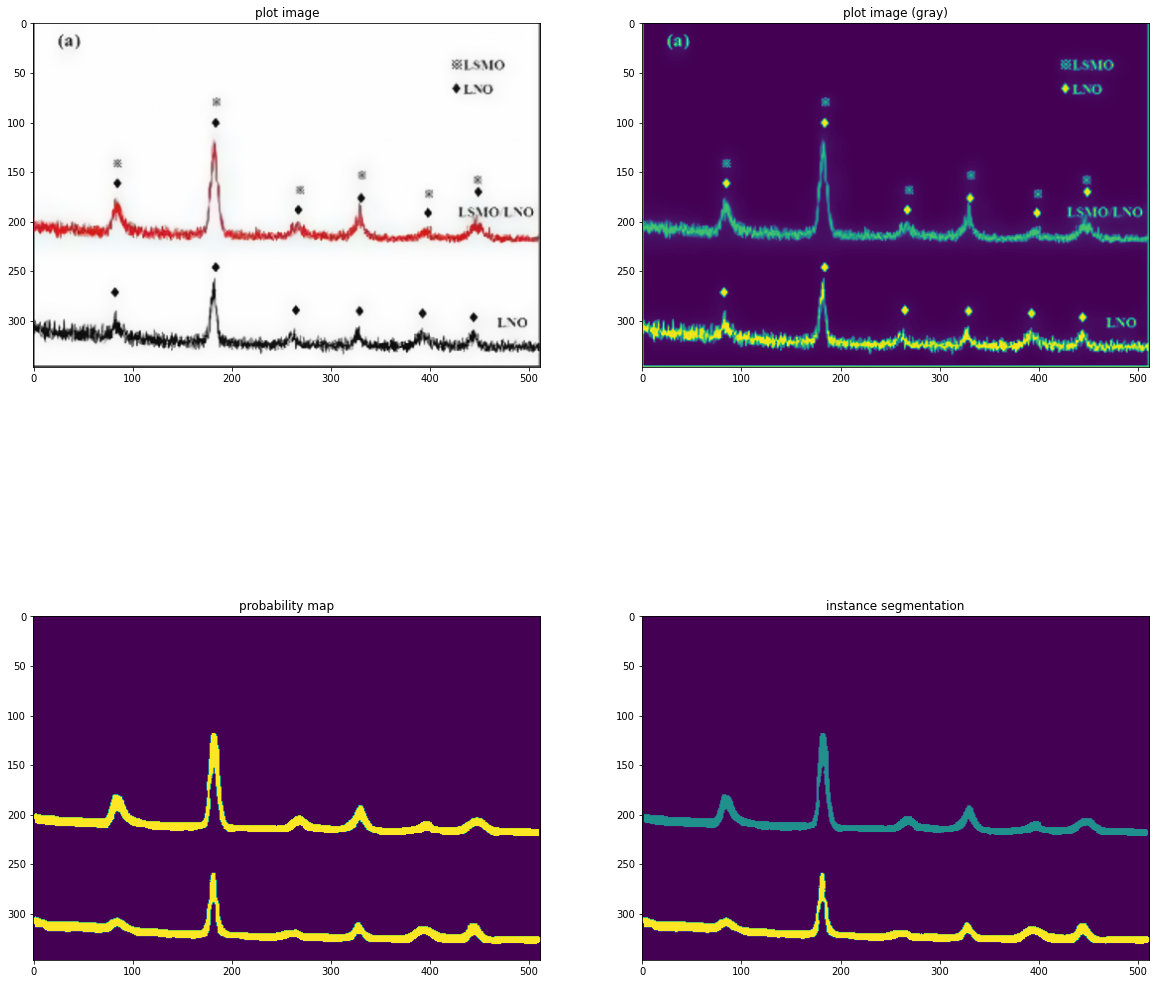

In [58]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(plot_digitizer.result_dict["visual"]["img_rgb"])
plt.title("plot image")
plt.subplot(2,2,2)
plt.imshow(plot_digitizer.result_dict["visual"]["img_gray"])
plt.title("plot image (gray)")
plt.subplot(2,2,3)
plt.imshow(plot_digitizer.result_dict["visual"]["seg_map"])
plt.title("probability map")
plt.subplot(2,2,4)
plt.imshow(plot_digitizer.result_dict["visual"]["ins_map"])
plt.title("instance segmentation")

In [54]:
h,w,_ = plot_digitizer.result_dict["visual"]["img_rgb"].shape
img_rgb = Image.open(plot_digitizer.img_name).convert("RGB")
canvas = img_rgb.resize((w,h))

## IMPORTANT
### set start_posi

In [55]:
start_posi = 300

## IMPORTANT
### set match_threshold

In [59]:
mode = "seg_gray_grads_posi_color_correction_grad_rejection_adaptive_dfs"
momentum = True
overlap_threshold = 0.
keep_order_threshold=0.
match_threshold=0.8
gradient_threshold = 20
color_neighbor_size=10
color_threshold=0.95
plot_digitizer.optical_flow.flow_prep(mode, 
                                      momentum,
                                     overlap_threshold = overlap_threshold,
                                     keep_order_threshold = keep_order_threshold,
                                     match_threshold = match_threshold,
                                     gradient_threshold = gradient_threshold,
                                     color_neighbor_size = color_neighbor_size,
                                     color_threshold = color_threshold)
plot_digitizer.optical_flow.flow(start_posi)
plot_digitizer.optical_flow.generate_lines()

(-0.5, 511.5, 346.5, -0.5)

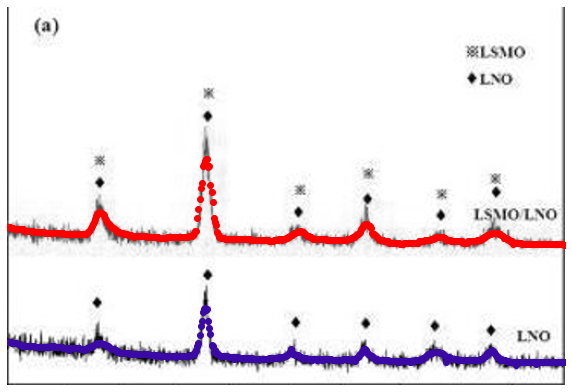

In [60]:
plt.figure(figsize=(10,10))
# canvas = np.ones_like(plot_digitizer.result_dict["visual"]["img_rgb"])
plt.imshow(canvas.convert("L"), cmap="gray")
plot_ts, plot_lines = plot_digitizer.optical_flow.line_set["plot"]
for line_id in range(plot_lines.shape[1]):
    plt.plot(plot_ts, plot_lines[:,line_id], "o", c=colors[line_id+5], markersize=6)
plt.axis("off")